# Survival Analysis with Differential Privacy

## Data Preprocessing

Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import random
from lifelines import KaplanMeierFitter

sns.set(style="whitegrid")
sns.set_context("notebook")

Read data

In [2]:
path_to_data = "../data/dataset/"

def load_data(name):
    data = pd.read_csv(os.path.join(path_to_data, name+".csv"))
    return data

Save results in a dictionary

In [3]:
names = ["cancer", "kidney", "mgus", "ovarian", "veteran"]
df_cancer = load_data(names[0]) #convert time to months, groups Male/Female(originally)
df_kidney = load_data(names[1]) #convert time to months, groups Male/Female(originally)
df_mgus = load_data(names[2]) #convert time to months, groups Male/Female(originally)
df_ovarian = load_data(names[3]) #convert time to months, groups treatment arms
df_veteran = load_data(names[4]) #convert time to months, groups treatment arms

In [4]:
#convert time to months
df_cancer['time'] = df_cancer['time']/30

<AxesSubplot:xlabel='timeline'>

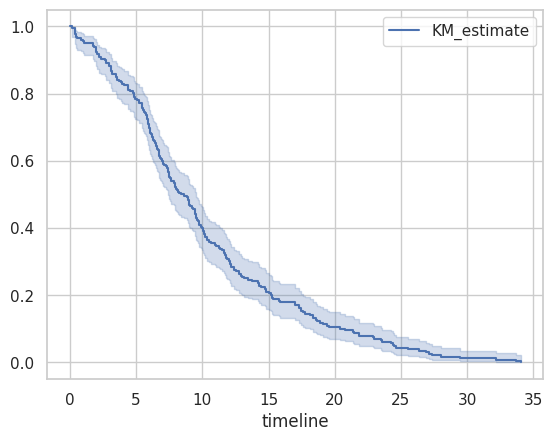

In [5]:
#compute KM for each dataset
kmf_cancer = KaplanMeierFitter()
kmf_cancer.fit(df_cancer["time"], event_observed=df_cancer["status"])
#plot KM
kmf_cancer.plot()

In [6]:
#convert time to months
df_kidney['time'] = df_kidney['time']/30

<AxesSubplot:xlabel='timeline'>

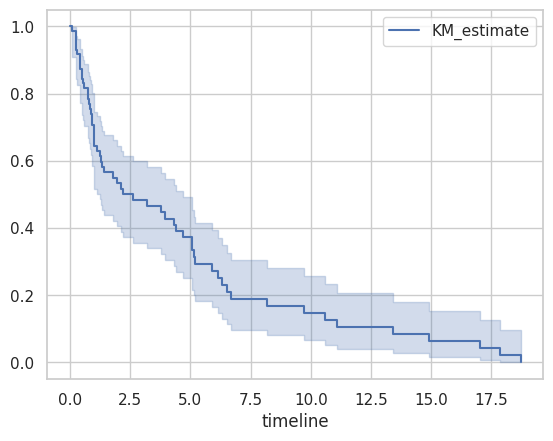

In [7]:
#compute KM for each dataset
kmf_kidney = KaplanMeierFitter()
kmf_kidney.fit(df_kidney["time"], event_observed=df_kidney["status"])
#plot KM
kmf_kidney.plot()

In [8]:
#convert time to months
df_mgus['time'] = df_mgus['time']/30

<AxesSubplot:xlabel='timeline'>

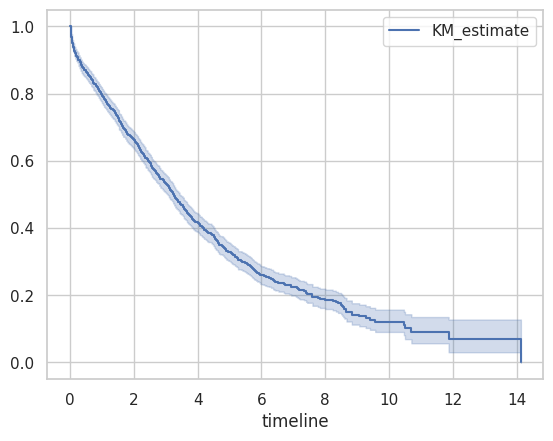

In [9]:
#compute KM for each dataset
kmf_mgus = KaplanMeierFitter()
kmf_mgus.fit(df_mgus["time"], event_observed=df_mgus["status"])
#plot KM
kmf_mgus.plot()

In [10]:
#convert time to months
df_ovarian["time"] = df_ovarian["time"]/30

<AxesSubplot:xlabel='timeline'>

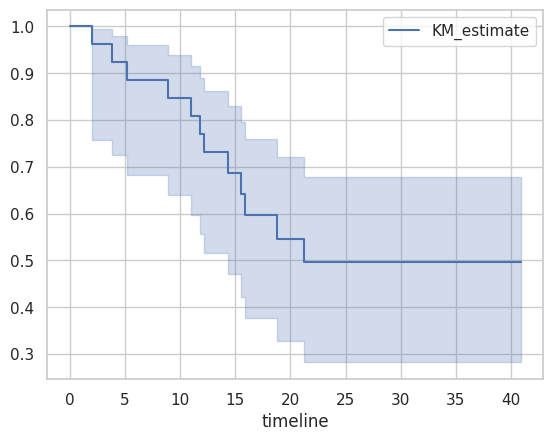

In [11]:
#compute KM for each dataset
kmf_ovarian = KaplanMeierFitter()
kmf_ovarian.fit(df_ovarian["time"], event_observed=df_ovarian["status"])
#plot KM
kmf_ovarian.plot()

In [12]:
#convert time to months
df_veteran["time"] = df_veteran["time"]/30

<AxesSubplot:xlabel='timeline'>

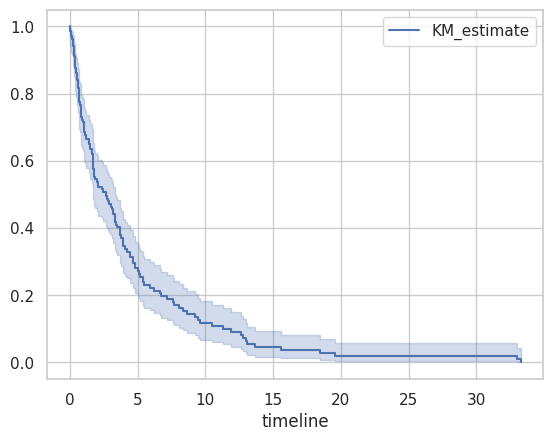

In [13]:
#compute KM for each dataset
kmf_veteran = KaplanMeierFitter()
kmf_veteran.fit(df_veteran["time"], event_observed=df_veteran["status"])
#plot KM
kmf_veteran.plot()

The plots above represents the KM curves for the different groups of patients in different datasets. The reproducibility of the results is checked with the paper of Gondara and Wang (2019) and the results are consistent.

## Laplacian Noise Time Obfuscation (LNTO)

@ARTICLE{Gondara_2019,title={Differentially Private Survival Function Estimation},year={2019},author={Lovedeep Gondara and Ke Wang}}

Survival function estimation is used in many disciplines, but it is most common in medical analytics in the form of the Kaplan-Meier estimator. Sensitive data (patient records) is used in the estimation without any explicit control on the information leakage, which is a significant privacy concern. We propose a first differentially private estimator of the survival function and show that it can be easily extended to provide differentially private confidence intervals and test statistics without spending any extra privacy budget. We further provide extensions for differentially private estimation of the competing risk cumulative incidence function. Using nine real-life clinical datasets, we provide empirical evidence that our proposed method provides good utility while simultaneously providing strong privacy guarantees.

In [14]:
#sort the dataframes by time
df_cancer.sort_values(by="time", inplace=True)
df_cancer.reset_index(inplace=True)
#count the number of status 2 at each time point
df_cancer["status_d"] = df_cancer["status"].apply(lambda x: 1 if x == 2 else 0)
df_cancer["status_d"] = df_cancer["status_d"].cumsum()
#compute the number of patients at risk at each time point
df_cancer["at_risk"] = df_cancer["status"].count() - df_cancer["status_d"]

In [15]:
def LNTO():
    return None

## Revised Randomized Response (RRR)

age range
(56.0, 63.0]      59
(38.999, 56.0]    58
(69.0, 82.0]      56
(63.0, 69.0]      55
Name: count, dtype: int64


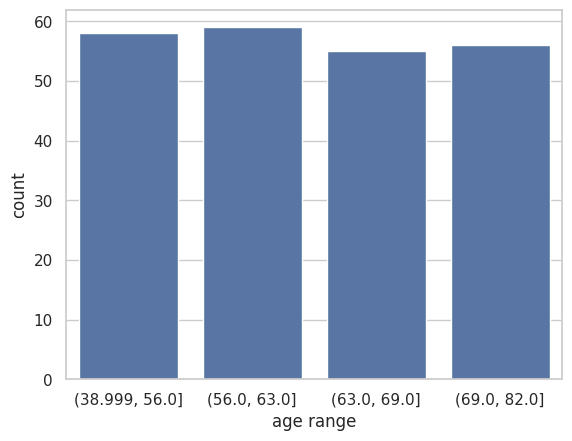

In [45]:
#devide cancer df into 4 groups per range age so that the number of patients in each group is equal

df_cancer["age range"] = pd.qcut(df_cancer["age"], 4)
#print the number of patients in each age range
print(df_cancer["age range"].value_counts())
#plot the number of patients in each age range
sns.countplot(x="age range", data=df_cancer)

#save the age ranges in a list
age_ranges = df_cancer["age range"].unique()

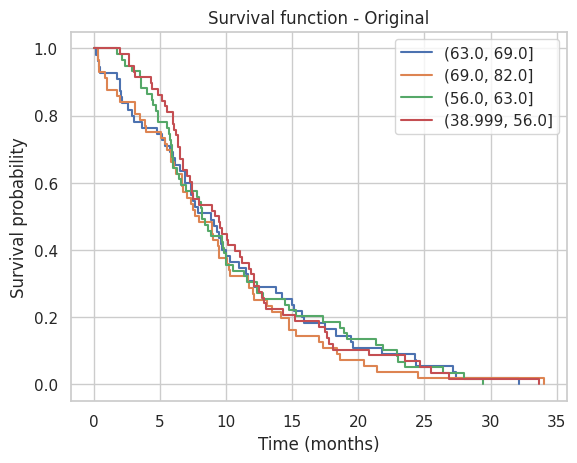

In [57]:
#compute KM for each age range
kmf_cancer_1 = KaplanMeierFitter()
kmf_cancer_2 = KaplanMeierFitter()
kmf_cancer_3 = KaplanMeierFitter()
kmf_cancer_4 = KaplanMeierFitter()

df_cancer_1 = df_cancer[df_cancer["age range"] == age_ranges[0]]
df_cancer_2 = df_cancer[df_cancer["age range"] == age_ranges[1]]
df_cancer_3 = df_cancer[df_cancer["age range"] == age_ranges[2]]
df_cancer_4 = df_cancer[df_cancer["age range"] == age_ranges[3]]

kmf_cancer_1.fit(df_cancer_1["time"], event_observed=df_cancer_1["status"])
kmf_cancer_2.fit(df_cancer_2["time"], event_observed=df_cancer_2["status"])
kmf_cancer_3.fit(df_cancer_3["time"], event_observed=df_cancer_3["status"])
kmf_cancer_4.fit(df_cancer_4["time"], event_observed=df_cancer_4["status"])

#plot KM for each age range getting the name of the age range from the unique values of the age range column
plt.figure()
kmf_cancer_1.plot(label=str(age_ranges[0]), ci_show=False)
kmf_cancer_2.plot(label=str(age_ranges[1]), ci_show=False)
kmf_cancer_3.plot(label=str(age_ranges[2]), ci_show=False)
kmf_cancer_4.plot(label=str(age_ranges[3]), ci_show=False)
plt.title("Survival function - Original")
plt.ylabel("Survival probability")
plt.xlabel("Time (months)")
plt.legend()
plt.show()

In [47]:
def RRR(age_range, n, p):
    def verify_epsilon(p,n):
        return np.log((n*p+1-p)/(n-1-n*p+p))
    
    epsilon = verify_epsilon(p,n)

    

In [48]:
def revised_coin_toss(df, column, category, p):
    n = len(df[column].unique())
    '''
    category: IPSS-R category, value to be privatized
    n: number of categories (not used in this function, used to compute the epsilon)
    p: coin bias
    '''
    # check if the possible epsilon is negative
    def verify_epsilon(p,n):
        return np.log((n*p+1-p)/(n-1-n*p+p))
        if epsilon <= 0:
            print('epsilon is negative for such values of p and n')
            exit()
        else:
            return epsilon
    
    # compute epsilon
    epsilon = verify_epsilon(p,n)

    # toss a coin H with probability p, T with probability 1-p
    coin = np.random.choice(['H', 'T'], p=[p, 1-p])

    # if coin is H, return the original value
    if coin == 'H':
        return category
    
    # if coin is T, return a random value from the n categories
    else:
        return random.choice(df[column].unique())


In [59]:
#apply revised_coin_toss to the age range column
df_cancer["priv age range"] = df_cancer["age range"].apply(lambda x: str(revised_coin_toss(df_cancer, "age range", x, 0.75)))


In [60]:
df_cancer["priv age range"].unique()

['(63.0, 69.0]', '(69.0, 82.0]', '(56.0, 63.0]', '(38.999, 56.0]']
Categories (4, object): ['(38.999, 56.0]' < '(56.0, 63.0]' < '(63.0, 69.0]' < '(69.0, 82.0]']

In [61]:
#use priv age range to compute KM for each age range
kmf_cancer_1 = KaplanMeierFitter()
kmf_cancer_2 = KaplanMeierFitter()
kmf_cancer_3 = KaplanMeierFitter()
kmf_cancer_4 = KaplanMeierFitter()

df_cancer_1 = df_cancer[df_cancer["priv age range"] == age_ranges[0]]
df_cancer_2 = df_cancer[df_cancer["priv age range"] == age_ranges[1]]
df_cancer_3 = df_cancer[df_cancer["priv age range"] == age_ranges[2]]
df_cancer_4 = df_cancer[df_cancer["priv age range"] == age_ranges[3]]


kmf_cancer_1.fit(df_cancer_1["time"], event_observed=df_cancer_1["status"])
kmf_cancer_2.fit(df_cancer_2["time"], event_observed=df_cancer_2["status"])
kmf_cancer_3.fit(df_cancer_3["time"], event_observed=df_cancer_3["status"])
kmf_cancer_4.fit(df_cancer_4["time"], event_observed=df_cancer_4["status"])
#plot KM for each age range getting the name of the age range from the unique values of the age range column
plt.figure()
kmf_cancer_1.plot(label=str(age_ranges[0]), ci_show=False)
kmf_cancer_2.plot(label=str(age_ranges[1]), ci_show=False)
kmf_cancer_3.plot(label=str(age_ranges[2]), ci_show=False)
kmf_cancer_4.plot(label=str(age_ranges[3]), ci_show=False)

plt.title("Survival function - DP")
plt.ylabel("Survival probability")
plt.xlabel("Time (months)")
plt.legend()
plt.show()
